# Modeling Risk with Monte Carlo Simulation

## 1. Stock Price Prediction Model

We are looking at 20 years of historical data to analyze the daily returns. 

In [1]:
# Import external packages
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

### Observations - Extract Data from Yahoo Finance

/Users/zakariyaboutayeb/anaconda3/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


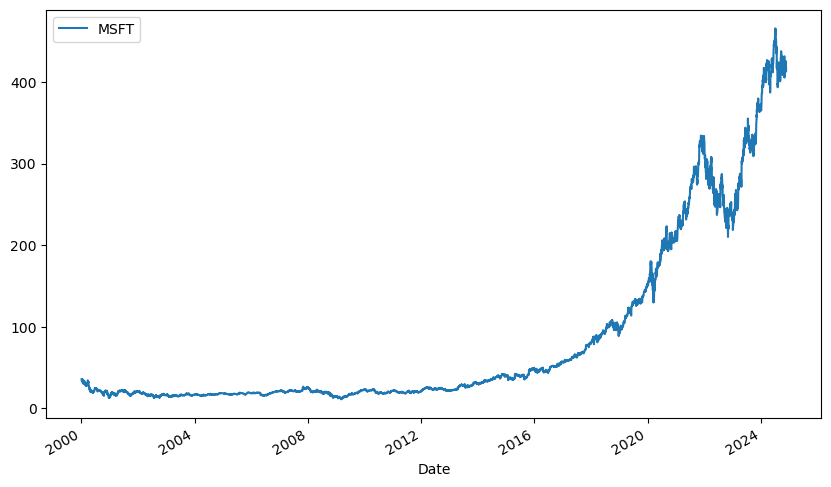

In [14]:
# Extract data from Yahoo Finance
ticker = 'MSFT' 
stock_data = pd.DataFrame()
stock_data[ticker] = yf.download(ticker, start='2000-1-1',end='2024-11-25')['Adj Close']

# Plot MSFT closing prices
stock_data.plot(figsize=(10, 6));

### Distributions - Calculate Historical Returns and Statistical Measures

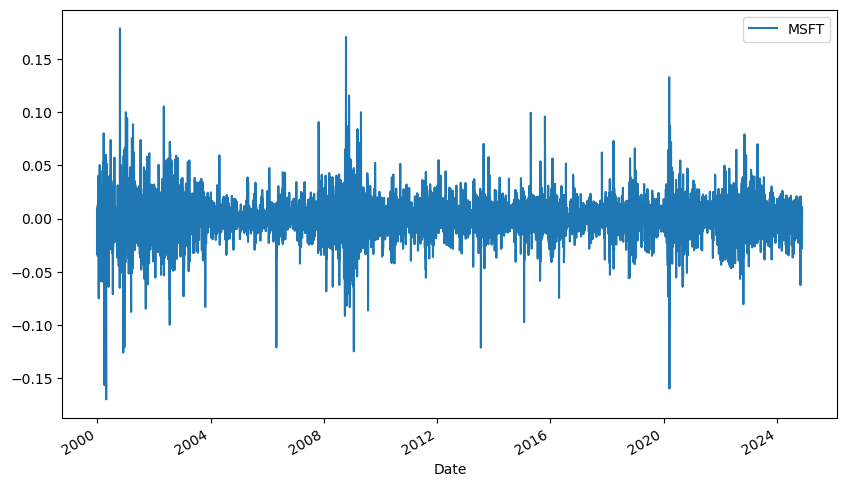

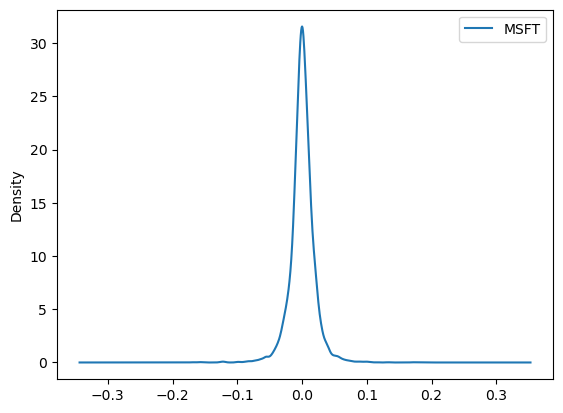

In [15]:
# Calculate historical log returns
log_returns = np.log(1 + stock_data.pct_change())

# Show all the log returns
log_returns.plot(figsize = (10, 6));

# Show the distribution of the log returns
log_returns.plot.density();

In [16]:
# Calculate key statistic measures
mean = log_returns.mean()
variance = log_returns.var()
STD = log_returns.std()

### Simulations - Simulate Future Daily Returns and Future Prices

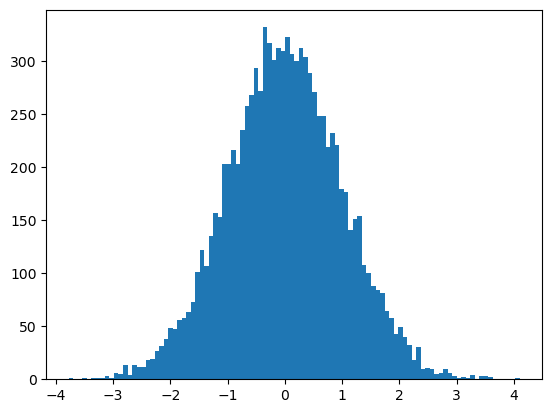

In [17]:
# How to generate 10,000 random numbers betwen 0 and 1.
random_numbers = np.random.rand(10000)

# Use those randomly generated numbers to sample from a normal distribution
normal_random_numbers = norm.ppf(random_numbers)

# Plot each of the 10,000 randombly generated numbers from the normal distribution
plt.hist(normal_random_numbers, bins = 100);

Note that the 10,000 normally distributed values ranging around from -4 to 4. This distribution has a mean of 0 and a standard deviation of 1. 

Now, let's set up our simulations. we'll forecast the stock price at the time of the following years, so that's about 250 trading days.

In [18]:
# Simulate future daily returns using the above method
t_intervals = 250 
simulations = 10000

daily_logreturns_simulated = STD.values * norm.ppf(np.random.rand(t_intervals, simulations))
daily_simplereturns_simulated = np.exp(daily_logreturns_simulated)
daily_simplereturns_simulated.shape

(250, 10000)

There are 250 columns and 10,000 rows, each row contains the predicting daily returns of the following 250 trading days. we've generated 10,000 versions of these values.

Next, we are going to use the daily simulated returns to forecast the stock price in the following year.

In [19]:
# Using returns, calculate future price progression in each simulation

# Latest known stock price for MSFT
last_price = stock_data.iloc[-1]

# Prepare an array for the price simulations
price_list = np.zeros_like(daily_simplereturns_simulated)

# Set the first row to the starting stock price
price_list[0] = last_price

price_list

array([[417., 417., 417., ..., 417., 417., 417.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

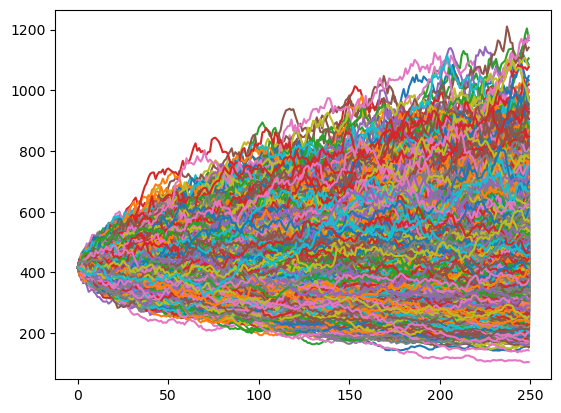

In [20]:
# Apply a for loop for simulated prices
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_simplereturns_simulated[t]

# Plot simulated future MSFT prices
plt.plot(price_list);

We can see all the 10,000 scenarios of the stock price changing in the following 250 days. At time 0, we have our last historical price of MSFT. Each line represents a simulation with a random and a unique price evolution drawn from a distribution which is defined by its past behavior. Therefore, we have 10,000 prices on the day 250 which represents all possible outcome.

### Including Drift

In [21]:
# Calculate drift
drift = mean - (0.5*variance)

# Simulate future daily returns
t_intervals = 250
simulations = 10000

daily_logreturns_simulated = STD.values * norm.ppf(np.random.rand(t_intervals, simulations))
daily_logreturns_simulated_withdrift = daily_logreturns_simulated + drift.values
daily_simplereturns_simulated_withdrift = np.exp(daily_logreturns_simulated_withdrift)

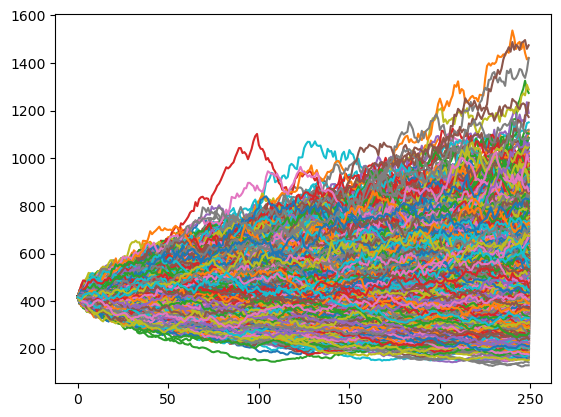

In [22]:
# Create a variable for the latest price of MSFT
last_price = stock_data.iloc[-1]

# Prepare an array for the price simulations
price_list = np.zeros_like(daily_simplereturns_simulated_withdrift)

# Set the first row to the starting stock price
price_list[0] = last_price

# Apply a for loop for simulated prices
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_simplereturns_simulated_withdrift[t]

# Plot simulated future MSFT prices
plt.plot(price_list);

Looking at out plot of simulations, we can see our distribution of results with a clear worst and best case scenario. 

### Quantifications - Examine the worst, average, best scenarios and the probability distribution

In [43]:
# Calculate worst, avg and best scenarios
WorstSim = round(price_list[-1].min(),2)
AvgSim = round(price_list[-1].mean(),2)
BestSim = round(price_list[-1].max(),2)

# Examine the worst, average, and best stock price sceanrios
print("Best and Worst Cases:")
print(f"Worst Simulation $/share: {WorstSim}")
print(f"Avg Simulation $/share: {AvgSim}")
print(f"Best Simulation $/share: {BestSim}")

# Set up confidence intervals
Mean_Day250Prices = price_list[-1].mean()
SD_Day250Prices = price_list[-1].std()
UpperInterval_1SD = Mean_Day250Prices + 1 * SD_Day250Prices 
LowerInterval_1SD = Mean_Day250Prices - 1 * SD_Day250Prices
UpperInterval_2SD = Mean_Day250Prices + 2 * SD_Day250Prices
LowerInterval_2SD = Mean_Day250Prices - 2 * SD_Day250Prices

# Print out the price range within the confidence intervals
print("\n" + "Confidence Intervals:")
print(f"1 Sigma (1 S.D): 68% confident that price after 250 days will fall between: ${LowerInterval_1SD} and ${round(UpperInterval_1SD,2)}")
print(f"2 Sigma (2 S.D): 95% confident that price after 250 days will fall between: ${round(LowerInterval_2SD,2)} and ${round(UpperInterval_2SD,2)}")

Best and Worst Cases:
Worst Simulation $/share: 131.03
Avg Simulation $/share: 460.44
Best Simulation $/share: 1474.73

Confidence Intervals:
1 Sigma (1 S.D): 68% confident that price after 250 days will fall between: $318.53980021710686 and $602.34
2 Sigma (2 S.D): 95% confident that price after 250 days will fall between: $176.64 and $744.23


## 2. Value at Risk Assessment Model

In this case, we will use monte Carlo simulation to assess the risk of purchasing 1,000 shares of MSFT shares and holding them for one month.  We will look at a 30-day historical data of Microsoft in this model. Instead of analyzing the data directly, we'll pull key information from different sources. The parameters we'll need in this model include the value of the investment at the current time and the volatility of the stock. Then we use these parameters to simulate the investment return of holding the stock for one month period. We'll generate 5,000 scenarios. Finally, based on how the 5,000 returns are distributed, we'll find out the one-month VaR at 90%, 95% and 99% confidence from these simulation results.  

When simulating MSFT stock price, we use a random walk to generate multiple plausible price paths and each simulation resulted in a single answer which is the price after 250 days. The answer will be derived from a formula in value at risk modeling, this is the VaR parametric approach:

Investment Return  = End Value - Present Value (PV) of the Investment

End Value = PV * e^((Rf - 0.5 * Vol^2) * t + z * σ)

where: 
z = randomly generated variable from a standard normal distribution
σ = historical standard deviation
t = the time in years
Rf = Risk free rate
Vol = Historical volatility

Each simulation uses the same formula to generate a simple answer which is the investment return for each simulation. Using the results of multiple simulations we'll then be able to summarize the distribution of investment returns and calculate the VaR in our single stock portfolio. 

### Import Packages

In [24]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

### Distributions - Set Up Stock Parameters

In [54]:
# Number of shares
shares_MSFT = 1000

# Live stock price
price = yf.Ticker('MSFT')
price_MSFT = price.history().tail(1)['Close'].iloc[0]

print('Final Price of MSFT:')
print('---------')
print(price_MSFT)

Final Price of MSFT:
---------
424.2799987792969


/Users/zakariyaboutayeb/anaconda3/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [26]:
# Investment value
value_MSFT = price_MSFT * shares_MSFT

# Risk free rate (4 week treasury bill rate)
rfr_MSFT = 0.02 

# Volatility (30-day volatility at that time)
vol_MSFT = 0.2785

30-day Historical volatility source: 

https://www.alphaquery.com/stock/MSFT/volatility-option-statistics/30-day/historical-volatility

### Simulations - Calculate Investment Returns

In [27]:
# Number of simulations
simulations = 5000 

# Investment time in a year
t_MSFT = 21/252 

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   2.,   1.,   2.,
          2.,   4.,   2.,   5.,   4.,   5.,  10.,  13.,   6.,   6.,   5.,
          9.,  11.,  16.,  19.,  16.,  22.,  23.,  27.,  29.,  39.,  48.,
         60.,  47.,  70.,  54.,  64.,  74.,  86.,  93.,  98., 100., 121.,
         98., 127., 143., 136., 120., 139., 120., 148., 128., 141., 159.,
        141., 147., 143., 138., 125., 143., 116., 106., 111., 116., 104.,
         91.,  81.,  93.,  88.,  75.,  58.,  66.,  58.,  44.,  42.,  31.,
         24.,  34.,  18.,  21.,  24.,  13.,  18.,  12.,   7.,  12.,   9.,
          9.,   5.,   2.,   1.,   3.,   2.,   4.,   3.,   2.,   0.,   2.,
          2.]),
 array([-3.87481993, -3.80292304, -3.73102615, -3.65912926, -3.58723237,
        -3.51533548, -3.44343859, -3.3715417 , -3.29964481, -3.22774792,
        -3.15585103, -3.08395414, -3.01205725, -2.94016036, -2.86826347,
        -2.79636658, -2.72446969, -2.6525728 , -2.58067591, -2.50877902,
        -2.43688213, -2.36

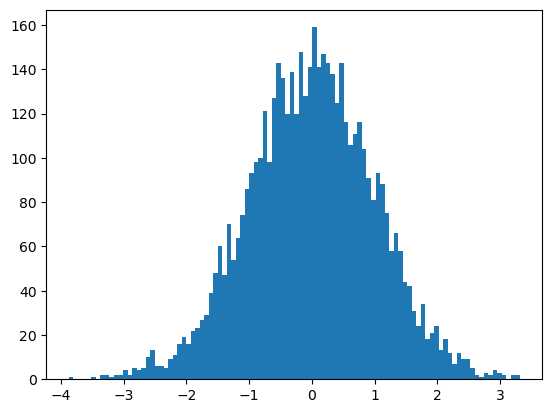

In [28]:
# Explain np.random.standard_normal
sample = np.random.standard_normal(5000)
plt.hist(sample,bins=100)

In [29]:
print(np.mean(sample))
print(np.std(sample))

-0.0056516482992517054
1.0032582446753322


Note that the mean is close to 0 and the standard deviation is close to 1 which matches the fact that we generated these samples based on a standard distribution. 

In [31]:
# Create a function to calculate the returns of the investment
def VaR(pv, rfr, vol, t, simulations):
    end_value = pv * np.exp((rfr - .5 * vol ** 2) * t + np.random.standard_normal(
        simulations) * vol * np.sqrt(t))
    returns = end_value - pv
    return returns

# Apply the VaR function to simulate the returns
returns_MSFT = VaR(value_MSFT, rfr_MSFT, vol_MSFT, t_MSFT, simulations)

### Quantifications - Identify VaR at 90%, 95%, and 99% Confidence Level

In [32]:
# Explain string formatting
# Print: VaR at x% confidence level: $y.

x = 0.9
y = 3455.248
print("VaR at {:.0%} confidence level: ${:,.0f}".format(x, y))

VaR at 90% confidence level: $3,455


VaR at 90% confidence level: $-31,369
VaR at 95% confidence level: $-39,292
VaR at 99% confidence level: $-53,875


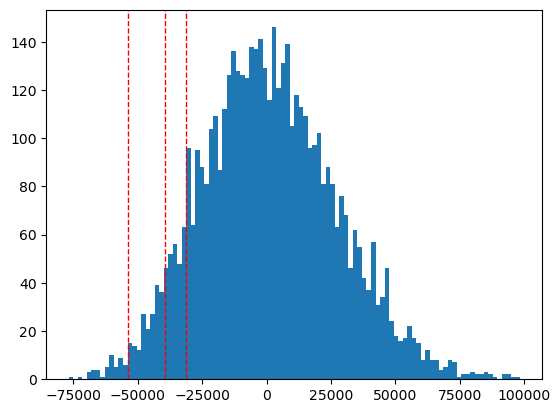

In [33]:
# Plot the returns
plt.hist(returns_MSFT, bins=100);

# Show VaR at 90%, 95%, and 99% confidence level
percentiles = [10,5,1]

for i in percentiles:
    confidence = (100-i)/100
    value = np.percentile(returns_MSFT, i)
    print("VaR at {:.0%} confidence level: ${:,.0f}".format(confidence, value))
    plt.axvline(value, color = 'red', linestyle='dashed', linewidth=1)

As the confidence level increases, the potential loss also increases because we're accounting for a larger range of potential negative outcomes.

VaR is used by risk managers to understand potential losses under normal market conditions, but it does not account for extreme events (tail risks) beyond the confidence level which is measured with CVaR. For example, a 99% VaR figure captures only 1% of the worst-case scenarios, leaving out the "tail" of extreme losses.